In [8]:
import os
import numpy as np
import struct
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

# Path to the Kaggle dataset
data_path = '/kaggle/input/mnist-dataset/'  # Adjust path if necessary

# Helper function to load MNIST files
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, 1, rows, cols)
        return images / 255.0  # Normalize to [0, 1]

def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# Load the data
train_images = load_mnist_images(os.path.join(data_path, 'train-images.idx3-ubyte'))
train_labels = load_mnist_labels(os.path.join(data_path, 'train-labels.idx1-ubyte'))
test_images = load_mnist_images(os.path.join(data_path, 't10k-images.idx3-ubyte'))
test_labels = load_mnist_labels(os.path.join(data_path, 't10k-labels.idx1-ubyte'))


In [9]:
# Custom PyTorch Dataset
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label



In [10]:
# Transformations (Add more if needed)
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])



In [11]:
# Create Datasets and DataLoaders
batch_size = 32  # Reduce this value if CUDA out-of-memory persists
train_dataset = MNISTDataset(train_images, train_labels, transform)
test_dataset = MNISTDataset(test_images, test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust based on pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor dynamically
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



Epoch 1, Loss: 0.005759325723925803
Epoch 2, Loss: 0.00394857614917448
Epoch 3, Loss: 0.007343074342354647
Epoch 4, Loss: 0.005177707163037282
Epoch 5, Loss: 0.00482237185304206
Training completed!


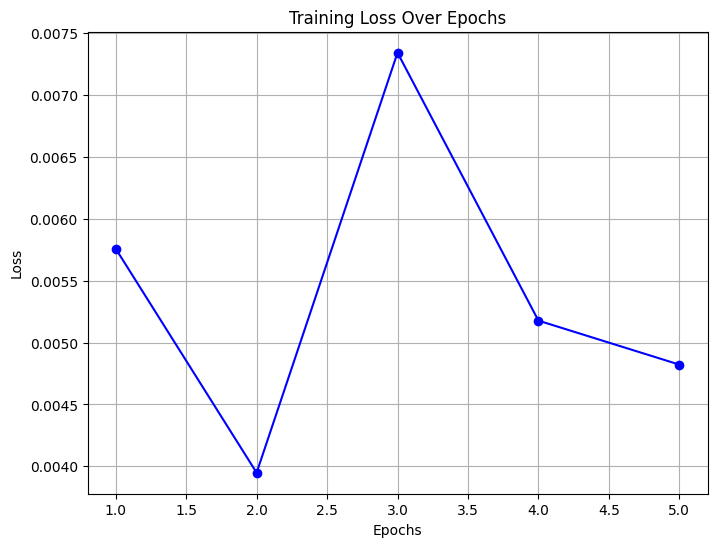

In [18]:
import matplotlib.pyplot as plt

# Initialize list to store training losses
training_losses = []

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)  # Store loss for each epoch
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

print("Training completed!")

# Plotting the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), training_losses, marker='o', linestyle='-', color='b')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()


In [19]:
from sklearn.metrics import accuracy_score, classification_report
import torch

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the class with the highest probability
        
        # Append predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))


Test Accuracy: 99.12%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import Normalize, Compose
import numpy as np
import os
import struct

# Load MNIST dataset as tensors
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        _, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, 1, rows, cols)
        return torch.tensor(images / 255.0, dtype=torch.float32)  # Normalize to [0, 1]

def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        _, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return torch.tensor(labels, dtype=torch.long)

# Dataset path
data_path = '/kaggle/input/mnist-dataset/'

# Load dataset
train_images = load_mnist_images(os.path.join(data_path, 'train-images.idx3-ubyte'))
train_labels = load_mnist_labels(os.path.join(data_path, 'train-labels.idx1-ubyte'))
test_images = load_mnist_images(os.path.join(data_path, 't10k-images.idx3-ubyte'))
test_labels = load_mnist_labels(os.path.join(data_path, 't10k-labels.idx1-ubyte'))

In [6]:
# Transformations
transform = Compose([
    Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

class MNISTDetectionDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Dummy bounding box covering the entire image
        boxes = torch.tensor([[0, 0, 28, 28]], dtype=torch.float32)
        labels = torch.tensor([label], dtype=torch.int64)
        
        # Convert single channel (1, H, W) to 3 channels (3, H, W)
        image = image.repeat(3, 1, 1)  # Repeat the single channel across 3 channels
        
        if self.transform:
            image = self.transform(image)
        
        # Faster R-CNN requires target dict with 'boxes' and 'labels'
        target = {'boxes': boxes, 'labels': labels}
        return image, target

In [7]:
# Create full training dataset
full_train_dataset = MNISTDetectionDataset(train_images, train_labels, transform=transform)

# Split the dataset into 70% training and 30% unused
train_size = int(0.7 * len(full_train_dataset))
unused_size = len(full_train_dataset) - train_size
train_dataset, _ = random_split(full_train_dataset, [train_size, unused_size])

# Test dataset
test_dataset = MNISTDetectionDataset(test_images, test_labels, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load Faster R-CNN model with ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust the classifier for MNIST (10 classes + background)
num_classes = 10 + 1  # Digits (0-9) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


In [ ]:
# Use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training Loop
epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        # Prepare images and targets for GPU
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

print("Training Complete!")

In [ ]:
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import numpy as np

# Function to compute IoU (Intersection over Union) for evaluation
def compute_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0 or len(true_boxes) == 0:
        return 0, 0, 0

    ious = box_iou(pred_boxes, true_boxes)
    true_positives = (ious > iou_threshold).any(dim=1).sum().item()
    false_positives = len(pred_boxes) - true_positives
    false_negatives = len(true_boxes) - true_positives

    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
    return precision, recall, f1_score

# Function to evaluate the model on test data
def evaluate_model(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    precision_list, recall_list, f1_list = [], [], []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Predictions
            outputs = model(images)
            
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes'].detach().cpu()
                true_boxes = target['boxes'].detach().cpu()
                
                # Compute metrics
                precision, recall, f1 = compute_metrics(pred_boxes, true_boxes, iou_threshold)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)
    
    # Aggregate metrics
    mean_precision = np.mean(precision_list)
    mean_recall = np.mean(recall_list)
    mean_f1 = np.mean(f1_list)
    
    print(f"Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, F1-score: {mean_f1:.4f}")
    return mean_precision, mean_recall, mean_f1

# Function to visualize predictions
def visualize_predictions(model, test_loader, device, num_images=5):
    model.eval()
    plt.figure(figsize=(20, 10))
    
    with torch.no_grad():
        for idx, (images, targets) in enumerate(test_loader):
            if idx >= num_images:
                break
            
            images = [img.to(device) for img in images]
            outputs = model(images)
            
            for i in range(len(images)):
                image = images[i].cpu().permute(1, 2, 0).numpy()
                pred_boxes = outputs[i]['boxes'].detach().cpu().numpy()
                true_boxes = targets[i]['boxes'].detach().cpu().numpy()
                
                plt.subplot(1, num_images, idx + 1)
                plt.imshow(image)
                plt.axis("off")
                
                # Plot predicted boxes
                for box in pred_boxes:
                    x1, y1, x2, y2 = box
                    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='r')
                
                # Plot true boxes
                for box in true_boxes:
                    x1, y1, x2, y2 = box
                    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color='g')
    
    plt.show()

# Evaluate the model
precision, recall, f1_score = evaluate_model(model, test_loader, device)

# Visualize predictions
visualize_predictions(model, test_loader, device)
